# Device objects
A series of short working examples here illustrate the use of labbench `Device` classes for experiment automation. The python programming interface is in the module of the same name, but it is convenient to import it as `lb` for shorthand.

In [1]:
import labbench as lb
lb.show_messages('debug')

## Brief context
### Role of subclasses 
The labbench module provides low-level python plumbing and utility functions to streamline lab automation, but not implementation for specific instrument or software. This specialization is meant to be written as Device subclasses in separate scripts or libraries.

Each specialized `Device` subclass represents a wrapper for python-style access to lower-level APIs used lab automation. Supplying these classes with connection and resource information instantiates them as Device _objects_ that represent connection to a physical device or software resource.

### Simulation examples
Working examples need functioning implementation, so since many laboratory automation instruments communicate with SCPI messages with VISA, the focus will be on simulated VISA devices.

The simulated virtual instruments are provided by [pyvisa-sim](pyvisa-sim.readthedocs.io/), and configured here in [sim_visa.yaml]. They are simple configuration value stores with some fixed traces.

Subclasses for communicating with the simulated instruments are implemented in [sim_visa.py]. They are subclassed as `lb.Device` -> `lb.VISADevice` -> `lb.SimulatedVISADevice`.

## Basic automation
To start, here is an automation script for automation control over 2 instruments in a very simple experiment.

 DEBUG  2021-05-25 08:14:19.234 • PowerSupply('USB::0x1111::0x2222::0x2468::INSTR'): opened
 DEBUG  2021-05-25 08:14:19.235 • SpectrumAnalyzer('GPIB::15::INSTR'): opened
 DEBUG  2021-05-25 08:14:19.236 • PowerSupply('USB::0x1111::0x2222::0x2468::INSTR'): write "':VOLT:IMM:AMPL 5.0'"
 DEBUG  2021-05-25 08:14:19.236 • PowerSupply('USB::0x1111::0x2222::0x2468::INSTR'): write "'OUTP 1'"
 DEBUG  2021-05-25 08:14:19.237 • SpectrumAnalyzer('GPIB::15::INSTR'): query_ascii_values 'TRACE?'
 DEBUG  2021-05-25 08:14:19.248 • SpectrumAnalyzer('GPIB::15::INSTR'):       -> (DataFrame with shape (201, 1))
 DEBUG  2021-05-25 08:14:19.285 • SpectrumAnalyzer('GPIB::15::INSTR'): closed
 DEBUG  2021-05-25 08:14:19.287 • PowerSupply('USB::0x1111::0x2222::0x2468::INSTR'): closed


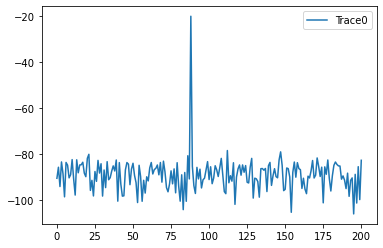

In [2]:
import labbench as lb
import numpy as np
from sim_visa import PowerSupply, SpectrumAnalyzer

# VISA Devices take a standard address string to create a resource
signal_analyzer = SpectrumAnalyzer('GPIB::15::INSTR')
supply = PowerSupply('USB::0x1111::0x2222::0x2468::INSTR')

# show SCPI traffic
lb.show_messages('debug')

with supply, signal_analyzer:
    supply.voltage = 5
    supply.output_enabled = True

    trace_dB = 10*np.log10(signal_analyzer.fetch_trace())

trace_dB.plot();

In [3]:
supply?

Type:           PowerSupply
String form:    PowerSupply('USB::0x1111::0x2222::0x2468::INSTR')
File:           c:\users\dkuester\documents\src\labbench\examples\sim_visa.py
Docstring:     
wrap the pyvisa-sim resource manager (resource '@sim')
        for emulated instruments for the purposes of software testing
        and demo 
    
Value Attributes:
    resource (str): device address or URI (allow_none=True)
    read_termination (str): end of line string for reads
    write_termination (str): end of line string for writes

Property Attributes:
    isopen (bool): is the backend ready?
    status_byte (dict): status byte reported by the instrument (sets=False)
    identity (str): identity string reported by the instrument (key='*IDN',sets=False,cache=True)
    options (str): options reported by the instrument (key='*OPT',sets=False,cache=True)
    voltage (float):  (key=':VOLT:IMM:AMPL',min=1,max=6)
    current (float):  (key=':CURR:IMM:AMPL',min=1,max=6)
    rail (str):  (key='INST',o

In [10]:
def traits(device):
    return dict(
        value=list(device._value_attrs),
        property=list(device._property_attrs),
        datareturn=list(device._datareturn_attrs)
    )

traits(supply)

{'value': ['resource',
  'concurrency',
  'read_termination',
  'write_termination',
  'yaml_source'],
 'property': ['isopen',
  'status_byte',
  'identity',
  'options',
  'voltage',
  'current',
  'rail',
  'output_enabled'],
 'datareturn': []}

### Generalizing from the example
Different subclasses expose different method functions and attribute variables to wrap the underling low-level API. Still, several characteristics are standardized:
- connection management through `with` block or `open`/`close` methods
- an `isopen` property to indicate connection status
- `resource` is accepted by the constructor, and may be changed afterward as a class attribute
- hooks are available for data loggers and UIs to observe automation calls


Device subclasses for different types of instruments and software differ in
- the types of resource and configuration information
- the specific resource of the class provided to control the device

This gets more complicated when handling multiple devices, because connection failures leave a combination of open and closed:

In [19]:
try:
    base.open()
    visa.open() # fails because its resource doesn't exist on the host
    
    # we don't get this far after visa.open() raises an exception
    print("doing useful automation here")
    visa.close()
    base.close()
except:    
    # we're left with a mixture of connection states
    assert base.isopen==True and visa.isopen==False

    # ...so we have to clean up the stray connection manually :(
    base.close()

Context management is easier and more clear. Everything inside the `with` block executes only if all devices open successfully, and ensures cleanup so that all devices are closed afterward.

In [18]:
try:
    with base, visa: # does both base.open() and visa.open()
        print('we never get in here, because visa.open() fails!')
except:
    # context management ensured a base.close() after visa.open() failed, 
    assert base.isopen==False and visa.isopen==False

In [ ]:

data logging, type checking,and numerical bounds validation. 

These features are common to all `Device` classes (and derived classes). To get started, provide  by minimum working examples. Examples will use  we'll look into the more specialized capabilities provided by other `Device` subclasses included `labbench` for often-used backend APIs like serial and VISA.

### Example
Here are very fake functions that just use `time.sleep` to block. They simulate longer instrument calls (such as triggering or acquisition) that take some time to complete.

Notice that `do_something_3` takes 3 arguments (and returns them), and that `do_something_4` raises an exception.

In [1]:
import labbench as lb

Here is the simplest example, where we call functions `do_something_1` and `do_something_2` that take no arguments and raise no exceptions:

In [2]:
from labbench import concurrently

results = concurrently(do_something_1, do_something_2)
results

start 1
start 2
end 1
end 2


{'do_something_1': 1, 'do_something_2': 2}

In [3]:
results

{'do_something_1': 1, 'do_something_2': 2}

In [4]:
do_something_1.__name__

'do_something_1'

We can also pass functions by wrapping the functions in `Call()`, which is a class designed for this purpose:

In [5]:
from labbench import concurrently, Call

results = concurrently(do_something_1, Call(do_something_3, 1,2,c=3))
results

start 1
start 3
end 1
end 3


{'do_something_1': 1, 'do_something_3': (1, 2, 3)}

More than one of the functions running concurrently may raise exceptions. Tracebacks print to the screen, and by default `ConcurrentException` is also raised:

In [6]:
from labbench import concurrently, Call

results = concurrently(do_something_4, do_something_5)
results

start 4
start 5


Traceback (most recent call last):
  File "<ipython-input-1-73606d5b193d>", line 24, in do_something_4
    raise ValueError('I had an error')
ValueError: I had an error
Traceback (most recent call last):
  File "<ipython-input-1-73606d5b193d>", line 31, in do_something_5
    raise IndexError('I had a different error')
IndexError: I had a different error
Traceback (most recent call last):
  File "C:\Users\dkuester\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-6e564c4e58e6>", line 3, in <module>
    results = concurrently(do_something_4, do_something_5)
  File "C:\Users\dkuester\AppData\Local\Continuum\anaconda3\lib\site-packages\labbench\util.py", line 899, in concurrently
    return concurrently_call(*objs, **kws)
  File "C:\Users\dkuester\AppData\Local\Continuum\anaconda3\lib\site-packages\labbench\util.py", line 600, in concurrently_call
    f

the `catch` flag changes concurrent exception handling behavior to return values of functions that did not raise exceptions (instead of raising `ConcurrentException`). The return dictionary only includes keys for functions that did not raise exceptions.

In [7]:
from labbench import concurrently, Call

results = concurrently(do_something_4, do_something_1, catch=True)
results

start 4
start 1
end 1


{'do_something_1': 1}